<a href="https://colab.research.google.com/github/ktbdls/Deep-Learning-Exploration-and-Interpretation-for-Skin-Lesion-Classification/blob/main/XceptionNet_and_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Mounting the Google Drive***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Inital Preping and Preprocessing of The Data***

In [2]:
# import os
# import numpy as np
# import pandas as pd
# from tensorflow.keras.preprocessing import image
# from tqdm import tqdm

# # call paths from drive
# IMAGE_DIR = '/content/drive/MyDrive/DISSERTATION/NEW/training/ISIC2018_Task3_Training_Input'  # Update with the path to your image dataset directory
# GROUND_TRUTH_PATH = '/content/drive/MyDrive/DISSERTATION/NEW/extracted_files/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'

# # load the ground truth data
# ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH)

# # image shape change - easier for processing
# IMG_HEIGHT, IMG_WIDTH = 224, 224

# # initialize lists to store images and labels to tranform from image files to .npy file
# image_data = []
# image_labels = []

# # loop through the ground truth file and process each image into the empty lists
# for index, row in tqdm(ground_truth_df.iterrows(), total=len(ground_truth_df)):
#     img_name = row['image']
#     label = row.drop('image').values  # The label is the remaining columns after 'image'

#     img_path = os.path.join(IMAGE_DIR, img_name + '.jpg')  # Assuming images are in .jpg format

#     try:
#         # load the images
#         img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
#         img_array = image.img_to_array(img)
#         image_data.append(img_array)
#         image_labels.append(label)
#     except Exception as e:
#         print(f"Error loading image {img_name}: {e}")

# # convert the lists to npy arrays for easier processing
# X = np.array(image_data, dtype='float32')
# y = np.array(image_labels, dtype='float32')

# # normalising the images to the range [0, 1]
# X /= 255.0

# np.save('ISIC2018_images.npy', X)
# np.save('ISIC2018_labels.npy', y)

# print(f"Image data shape: {X.shape}")
# print(f"Label data shape: {y.shape}")


***Installing and Importing***

In [3]:
# install for XAI later
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.2 MB/s eta 0:00:00


In [4]:
# libraries and tools
import os
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

***Loading The Data***

In [5]:
# load previously converted data
data = np.load('/content/drive/MyDrive/DISSERTATION/NEW/ISIC2018_images.npy',mmap_mode='r')
labels = np.load('/content/drive/MyDrive/DISSERTATION/NEW/ISIC2018_labels.npy',mmap_mode='r')

# prin to viusualise shape
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (10015, 224, 224, 3)
Labels shape: (10015, 7)


***Further Preprocessing and Visualising***

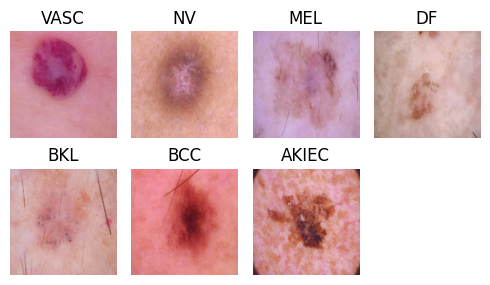

In [6]:
# gather unique class labels and their corresponding indices in the npy array
unique_classes = np.unique(labels, axis=1)

# create a dictionary to store one data sample from each class
class_samples = {}

# add class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# select one data sample from each class to display
for class_label in unique_classes:
    class_indices = np.where(np.all(labels == class_label, axis=1))[0]
    class_samples[tuple(class_label)] = data[class_indices[0]]

# show images in 2 rows
plt.figure(figsize=(5, 3))
for i, (class_label, image_data) in enumerate(class_samples.items()):
    class_index = np.argmax(class_label)  # index of the class
    class_name = class_names[class_index]  # corresponding class name
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')

# print to chack and visualise
plt.tight_layout()
plt.show()

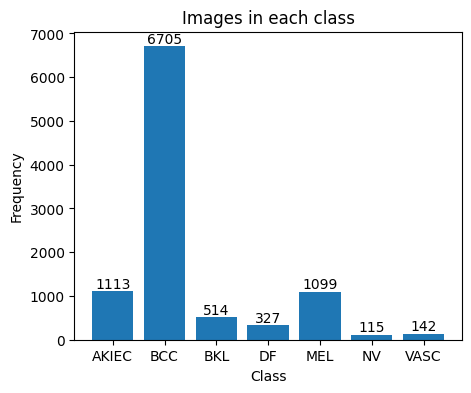

In [7]:
# sum the one-hot encoded labels across the rows to calculate the frequency of each class
class_counts = np.sum(labels, axis=0)

# associate class indices with their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# plot the class frequencies for visual analysis of data spread
plt.figure(figsize=(5, 4))
plt.bar([class_names[class_idx] for class_idx in range(len(class_names))], class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in each class')

# annotate each bar with their class frequency (in integers)
for i, count in enumerate(class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

In [8]:
# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1,stratify=labels, random_state=42) # randomly split
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1,stratify=train_labels, random_state=42)

In [9]:
# print to check split shapes
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)

# shows split 80/9/11

train_data shape: (8111, 224, 224, 3)
train_labels shape: (8111, 7)
val_data shape: (902, 224, 224, 3)
val_labels shape: (902, 7)
test_data shape: (1002, 224, 224, 3)
test_labels shape: (1002, 7)


In [10]:
class_names_mapping = {
    0: "AKIEC",
    1: "BCC",
    2: "BKL",
    3: "DF",
    4: "MEL",
    5: "NV",
    6: "VASC"
}
# calculate class distribution of the sets
num_classes = train_labels.shape[1]
class_counts_train = np.sum(train_labels, axis=0)
class_counts_val = np.sum(val_labels, axis=0)
class_counts_test = np.sum(test_labels, axis=0)

class_counts_mapping = {}
for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name] = {'Train': class_counts_train[index]}

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Validation'] = class_counts_val[index]

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Test'] = class_counts_test[index]

# print to visualise for each set
for class_name, counts in class_counts_mapping.items():
    print(class_name)
    for set_name, count in counts.items():
        print(f" - {set_name}: {count}")

# BCC has the highest - highly imbalanced

AKIEC
 - Train: 902.0
 - Validation: 100.0
 - Test: 111.0
BCC
 - Train: 5430.0
 - Validation: 604.0
 - Test: 671.0
BKL
 - Train: 417.0
 - Validation: 46.0
 - Test: 51.0
DF
 - Train: 264.0
 - Validation: 30.0
 - Test: 33.0
MEL
 - Train: 890.0
 - Validation: 99.0
 - Test: 110.0
NV
 - Train: 93.0
 - Validation: 10.0
 - Test: 12.0
VASC
 - Train: 115.0
 - Validation: 13.0
 - Test: 14.0


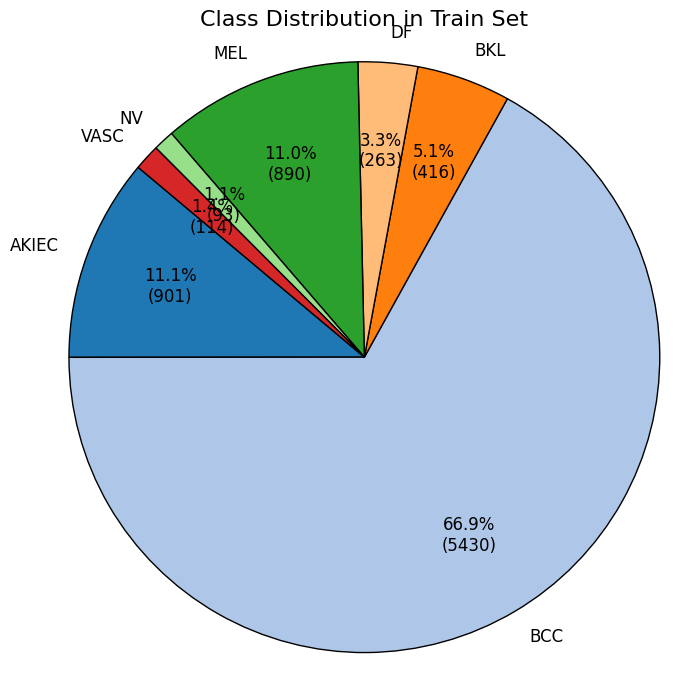

In [11]:
# make visual pie charts
import matplotlib.pyplot as plt

# function to format pie chart labels (value and percentage)
def func(pct, all_values):
    absolute = int(pct/100.*sum(all_values))
    return f'{pct:.1f}%\n({absolute})'

# define colour scheme
colors = plt.get_cmap('tab20').colors  # Use a colormap for consistent styling

for set_name in ['Train']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(7, 7))  # a larger figure to see separation better
    plt.pie(
        class_counts,
        labels=class_labels,
        colors=colors[:len(class_counts)],
        startangle=140,
        autopct=lambda pct: func(pct, class_counts),
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 12},  # bigger label font size
        pctdistance=0.7 # % labels were overlapping
    )
    plt.title(f'Class Distribution in {set_name} Set', fontsize=16)
    plt.axis('equal')  # a circle
    plt.tight_layout()  # Adjust layout to prevent labels from getting cut off
    plt.show()

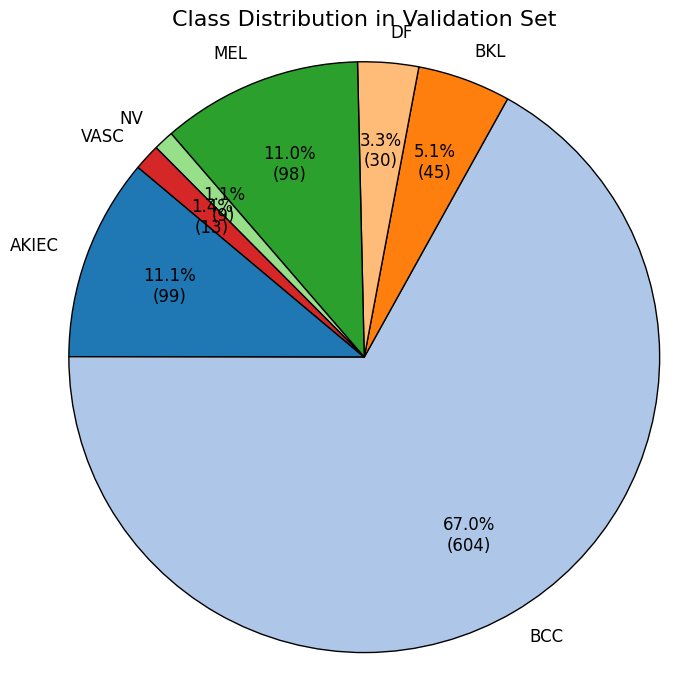

In [12]:
# make visual pie charts
import matplotlib.pyplot as plt

# function to format pie chart labels (value and percentage)
def func(pct, all_values):
    absolute = int(pct/100.*sum(all_values))
    return f'{pct:.1f}%\n({absolute})'

# define colour scheme
colors = plt.get_cmap('tab20').colors  # Use a colormap for consistent styling

for set_name in ['Validation']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(7, 7))  # a larger figure to see separation better
    plt.pie(
        class_counts,
        labels=class_labels,
        colors=colors[:len(class_counts)],
        startangle=140,
        autopct=lambda pct: func(pct, class_counts),
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 12},  # bigger label font size
        pctdistance=0.7 # % labels were overlapping
    )
    plt.title(f'Class Distribution in {set_name} Set', fontsize=16)
    plt.axis('equal')  # a circle
    plt.tight_layout()  # Adjust layout to prevent labels from getting cut off
    plt.show()

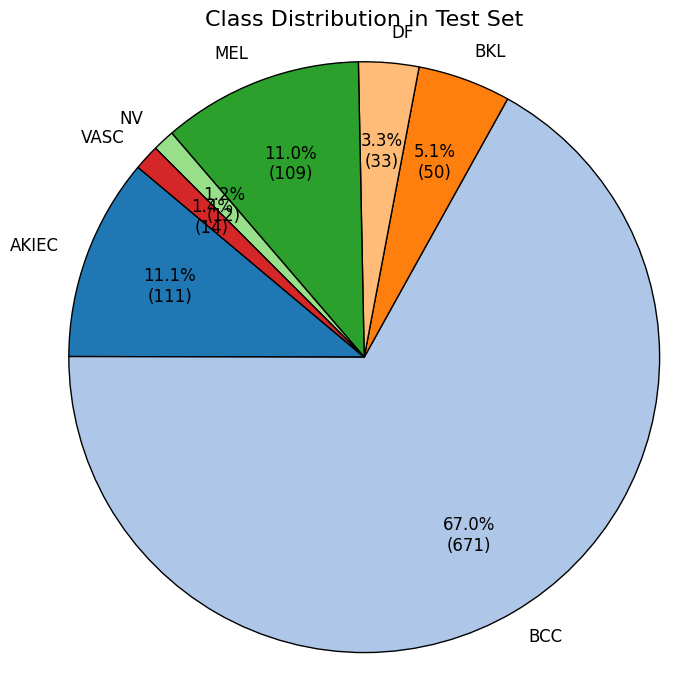

In [13]:
# make visual pie charts
import matplotlib.pyplot as plt

# function to format pie chart labels (value and percentage)
def func(pct, all_values):
    absolute = int(pct/100.*sum(all_values))
    return f'{pct:.1f}%\n({absolute})'

# define colour scheme
colors = plt.get_cmap('tab20').colors  # Use a colormap for consistent styling

for set_name in ['Test']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(7, 7))  # a larger figure to see separation better
    plt.pie(
        class_counts,
        labels=class_labels,
        colors=colors[:len(class_counts)],
        startangle=140,
        autopct=lambda pct: func(pct, class_counts),
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 12},  # bigger label font size
        pctdistance=0.7 # % labels were overlapping
    )
    plt.title(f'Class Distribution in {set_name} Set', fontsize=16)
    plt.axis('equal')  # a circle
    plt.tight_layout()  # Adjust layout to prevent labels from getting cut off
    plt.show()

***Augmenting The Data***

In [14]:
# data augmentation during training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

***Building The Model***

In [15]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', min_lr=1e-4, verbose=1)
saved_model = '/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras'
model_chkpt = ModelCheckpoint(saved_model, save_best_only=True, monitor='val_accuracy', verbose=1) #saves the best version of the model for further training

# List of callbacks
callback_list = [model_chkpt, lr_reduce]

In [16]:
base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [17]:
x = base_model.output
x = GlobalAveragePooling2D()(x) # bridge CNN to fully connected layers
x = Dense(128, activation='relu')(x) # relu activation fuction for added layers ontop of CNN - great for learing complex patterns in the image data
x = Dropout(0.5)(x) # prevent overfitting
predictions = Dense(7, activation='softmax')(x) # 7 classes to output with softmax to put each raw output score into its probable class

# create the final model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)


# compile model with adam optimiser
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
epochs = 50
batch_size = 16

***Training The Model***

In [19]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6668 - loss: 1.0360
Epoch 1: val_accuracy improved from -inf to 0.73614, saving model to /content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras
507/507 ━━━━━━━━━━━━━━━━━━━━ 190s 270ms/step - accuracy: 0.6669 - loss: 1.0358 - val_accuracy: 0.7361 - val_loss: 0.8480 - learning_rate: 0.0010
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7187 - loss: 0.8143
Epoch 2: val_accuracy did not improve from 0.73614
507/507 ━━━━━━━━━━━━━━━━━━━━ 84s 163ms/step - accuracy: 0.7187 - loss: 0.8143 - val_accuracy: 0.7084 - val_loss: 0.9698 - learning_rate: 0.0010
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7376 - loss: 0.7338
Epoch 3: val_accuracy did not improve from 0.73614
507/507 ━━━━━━━━━━━━━━━━━━━━ 84s 164ms/step - accuracy: 0.7376 - loss: 0.7338 - val_accuracy: 0.6630 - val_loss: 1.1950 - learning_rate: 0.0010
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7526 - lo

In [20]:
model= load_model('/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras')

In [21]:
epochs = 10

***Retraining***

In [22]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9816 - loss: 0.0503
Epoch 1: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 132s 197ms/step - accuracy: 0.9816 - loss: 0.0503 - val_accuracy: 0.8016 - val_loss: 1.2384 - learning_rate: 1.0000e-04
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9847 - loss: 0.0432
Epoch 2: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9847 - loss: 0.0432 - val_accuracy: 0.8004 - val_loss: 1.1521 - learning_rate: 1.0000e-04
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9858 - loss: 0.0385
Epoch 3: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - accuracy: 0.9858 - loss: 0.0385 - val_accuracy: 0.8293 - val_loss: 1.1543 - learning_rate: 1.0000e-04
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9894 - loss: 0.0369
Epoch 4: val_accuracy did not improve from 0.83814

In [23]:
model= load_model('/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras')

In [24]:
epochs = 5

In [25]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9855 - loss: 0.0444
Epoch 1: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 133s 199ms/step - accuracy: 0.9855 - loss: 0.0444 - val_accuracy: 0.8049 - val_loss: 1.3031 - learning_rate: 1.0000e-04
Epoch 2/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9854 - loss: 0.0456
Epoch 2: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9854 - loss: 0.0456 - val_accuracy: 0.7971 - val_loss: 1.3321 - learning_rate: 1.0000e-04
Epoch 3/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9876 - loss: 0.0431
Epoch 3: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9876 - loss: 0.0431 - val_accuracy: 0.8182 - val_loss: 1.0775 - learning_rate: 1.0000e-04
Epoch 4/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9867 - loss: 0.0419
Epoch 4: val_accuracy did not improve from 0.83814
507

In [26]:
model= load_model('/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras')

***Testing The Model on Unseen Data***

In [27]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.8541 - loss: 0.8979
Test Accuracy: 0.8552893996238708


In [28]:
# use test data to get predictions
predictions = model.predict(test_data)

# convert preds to int values
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# gather report
report = classification_report(true_labels, predicted_labels)

# print for visual
print("Classification Report:")
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.80      0.67       111
           1       0.97      0.90      0.93       671
           2       0.93      0.76      0.84        51
           3       0.93      0.42      0.58        33
           4       0.64      0.85      0.73       110
           5       0.78      0.58      0.67        12
           6       1.00      0.86      0.92        14

    accuracy                           0.86      1002
   macro avg       0.83      0.74      0.76      1002
weighted avg       0.88      0.86      0.86      1002



In [29]:
# get the numbers for confusion matrix
cm = confusion_matrix(true_labels, np.round(predicted_labels))

cm

array([[ 89,   9,   0,   0,  13,   0,   0],
       [ 44, 602,   2,   0,  22,   1,   0],
       [  1,   2,  39,   0,   9,   0,   0],
       [  9,   0,   1,  14,   8,   1,   0],
       [ 10,   6,   0,   0,  94,   0,   0],
       [  2,   0,   0,   1,   2,   7,   0],
       [  1,   1,   0,   0,   0,   0,  12]])

Normalized confusion matrix


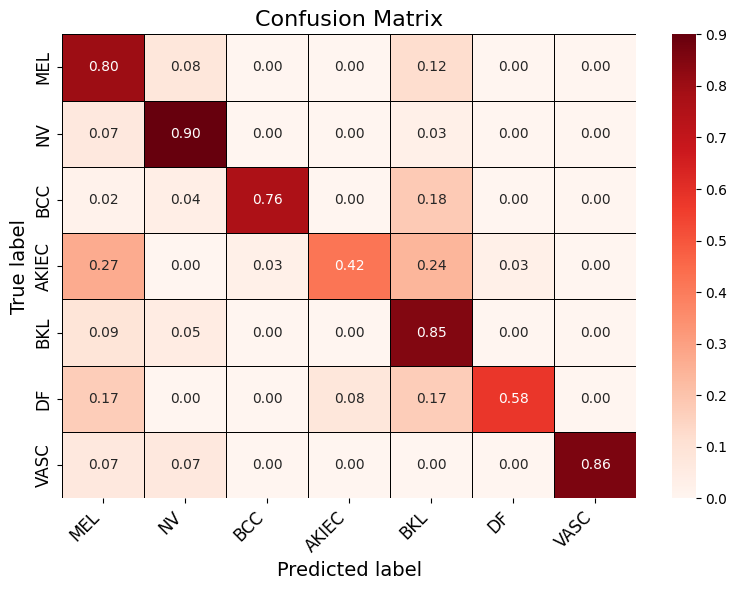

In [30]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Reds):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)  # 2 decimal places
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                linewidths=0.5, linecolor='black', cbar=True,
                xticklabels=classes, yticklabels=classes)

    plt.title(title, fontsize=16)
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

cm_plot_labels = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

# print cm
plot_confusion_matrix(cm, cm_plot_labels, normalize=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


<ipython-input-31-90f4d3ddb0b7>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colours = cycle(plt.cm.get_cmap('tab10').colors)


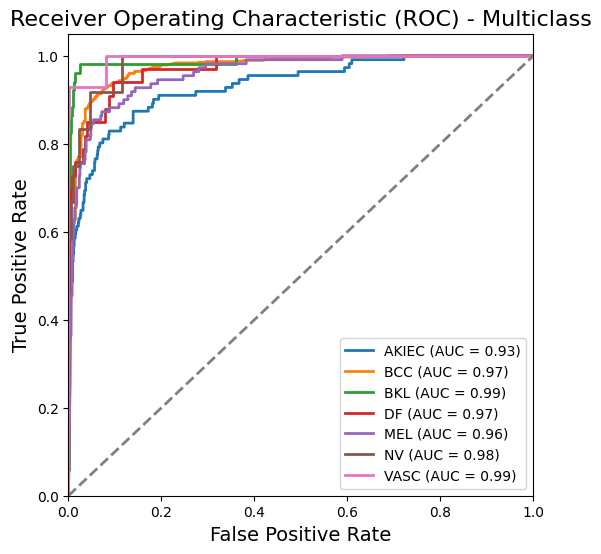

In [31]:
from itertools import cycle

# names
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# use prediction data
predictions = model.predict(test_data)

# no. of classes
num_classes = test_labels.shape[1]

# add colour scheme!!
colours = cycle(plt.cm.get_cmap('tab10').colors)

# plot size
plt.figure(figsize=(6, 6))

# loop through for each of the classes
for class_index, colour in zip(range(num_classes), colours):
    # calc ROC curve and ROC AUC for the specific class
    fpr, tpr, thresholds = roc_curve(test_labels[:, class_index], predictions[:, class_index])
    roc_auc = auc(fpr, tpr)

    # plot it
    plt.plot(fpr, tpr, color=colour, lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc:.2f})')

# plot diagonal line to see if the model is performing better than "random"
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# graph properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) - Multiclass', fontsize=16)
plt.legend(loc='lower right', fontsize=10)

plt.show()

In [32]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
gpus = [device.name for device in device_list if device.device_type == 'GPU']
print('TensorFlow recognized {} GPUs'.format(len(gpus)))

TensorFlow recognized 1 GPUs


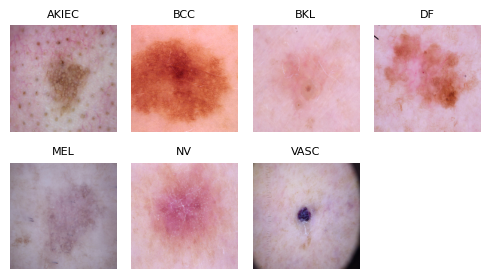

In [33]:
image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)

# convert to integer labels
test_labels_int = np.argmax(test_labels, axis=1)
# find the indices of the first image from each class
class_indices = [np.where(test_labels_int == i)[0][0] for i in range(len(image_titles))]

# store the images
image_array = []

# subplots with 2 rows
num_rows = 2
num_cols = (num_images + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].set_title(title, fontsize=8)

    # predicted images test data
    img = test_data[class_indices[i]]
    image_array.append(img)  # add to store

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))

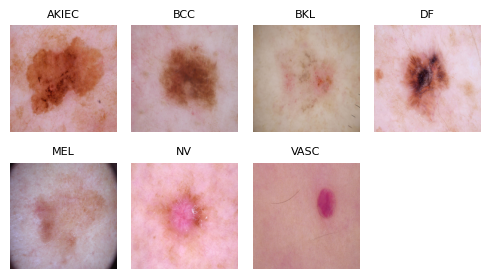

In [34]:
image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)

# convert to integer labels
test_labels_int = np.argmax(test_labels, axis=1)

# store the images
image_array = []

# subplots with 2 rows
num_rows = 2
num_cols = (num_images + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].set_title(title, fontsize=8)

    # find indices of images for specific class
    class_indices = np.where(test_labels_int == i)[0]
    random_index = np.random.choice(class_indices)  # define random index

    # predicted images test data
    img = test_data[random_index]
    image_array.append(img)  # store

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))

In [35]:
replace2linear = ReplaceToLinear()

In [36]:
score = CategoricalScore([0, 1, 2, 3, 4, 5, 6])

***Saliency maps***

---



---



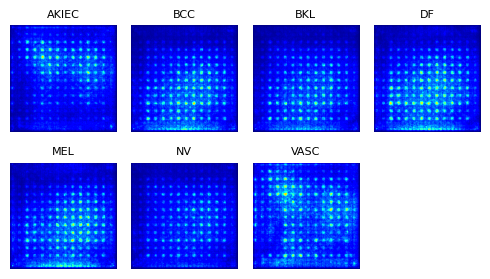

CPU times: user 7.34 s, sys: 390 ms, total: 7.73 s
Wall time: 7.98 s


In [37]:
%%time
from keras import backend as K
from tf_keras_vis.saliency import Saliency

# create saliency
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# create map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # no. of calculating gradients iterations
                        smooth_noise=0.20) # how much the noise is spread

# subplot features
num_rows = 2
num_cols = (num_images + 1) // num_rows

# rendering
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(saliency_map[i], cmap='jet')
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

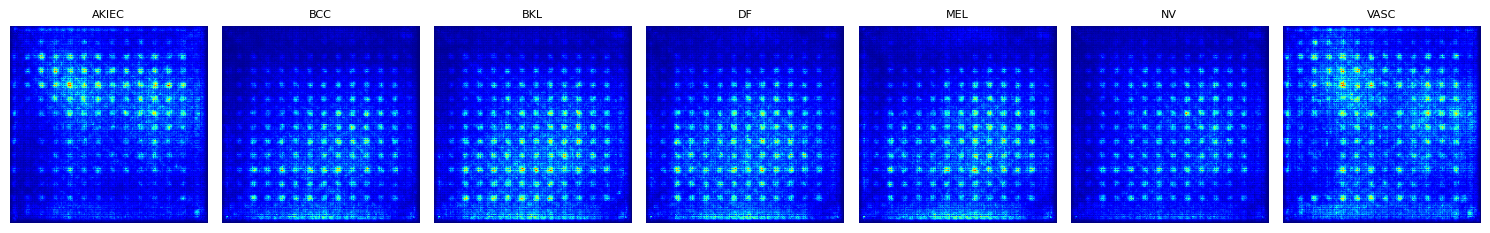

CPU times: user 6.55 s, sys: 341 ms, total: 6.89 s
Wall time: 6.55 s


In [38]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# create saliency
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# create map with smoothing that reduce noise by adding noise
saliency_maps = saliency(score,
                         X,
                         smooth_samples=20,
                         smooth_noise=0.20)

# no. of images
num_images = len(image_titles)

# one row instead of 2 this time
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    axes[i].set_title(title, fontsize=8)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

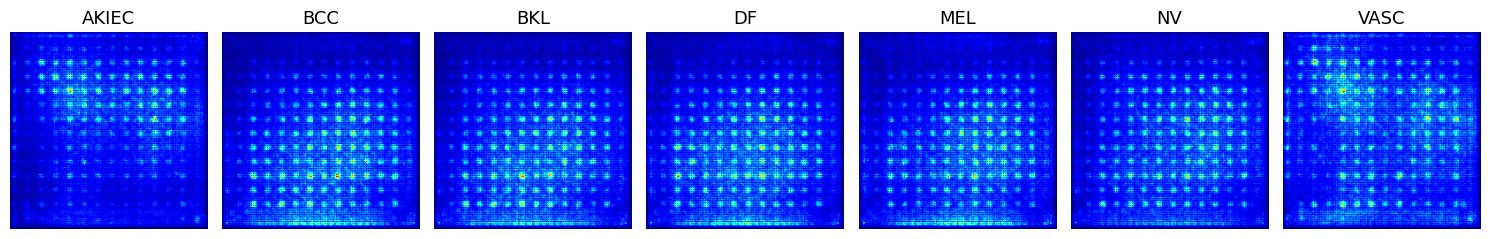

CPU times: user 6.58 s, sys: 349 ms, total: 6.93 s
Wall time: 6.58 s


In [39]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# create saliency
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# create map with smoothing that reduce noise by adding noise
saliency_maps = saliency(score,
                         X,
                         smooth_samples=20,
                         smooth_noise=0.20)

# no. of images
num_images = len(image_titles)

# one row
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    axes[i].set_title(title, fontsize=13)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()



---



---



In [40]:
# model.summary()

# # Alternatively, to print only convolutional layers:
# for layer in model.layers:
#     if 'conv' in layer.name:
#         print(layer.name)

In [41]:
# # Get model's prediction confidence for all images
# model_output = model.predict(X)

# # Print out the confidence for each class for each image
# for i, prediction in enumerate(model_output):
#     print(f"Image {i}: {prediction}")

In [42]:
# # Check the model's predictions for the input images
# model_output = model.predict(X)

# # Print the confidence for each class for each image
# for i, prediction in enumerate(model_output):
#     print(f"Image {i} Predictions: {prediction}")
#     print(f"Class with max confidence: {np.argmax(prediction)}")

# # Get the distribution of predicted classes
# predicted_classes = np.argmax(model_output, axis=1)
# unique, counts = np.unique(predicted_classes, return_counts=True)
# class_distribution = dict(zip(unique, counts))

# print(f"Predicted class distribution: {class_distribution}")

In [43]:
# # Assuming `y_train` contains your training labels
# unique, counts = np.unique(train_labels, return_counts=True)
# class_distribution = dict(zip(unique, counts))

# print(f"Training set class distribution: {class_distribution}")

***XAI models***

---



---



12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 521ms/step


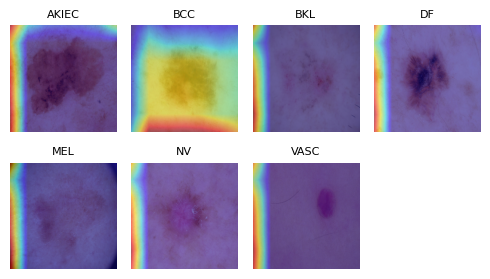

CPU times: user 17.9 s, sys: 591 ms, total: 18.5 s
Wall time: 13.7 s


In [44]:
#FASTER SCORECAM

%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam

# create scorecam variable
scorecam = Scorecam(model, model_modifier=replace2linear)

# implement faster scorecam parameters
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=50)

# subplot features
num_rows = 2
num_cols = (num_images + 1) // num_rows

# rendering
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(image_array[i])
    ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step


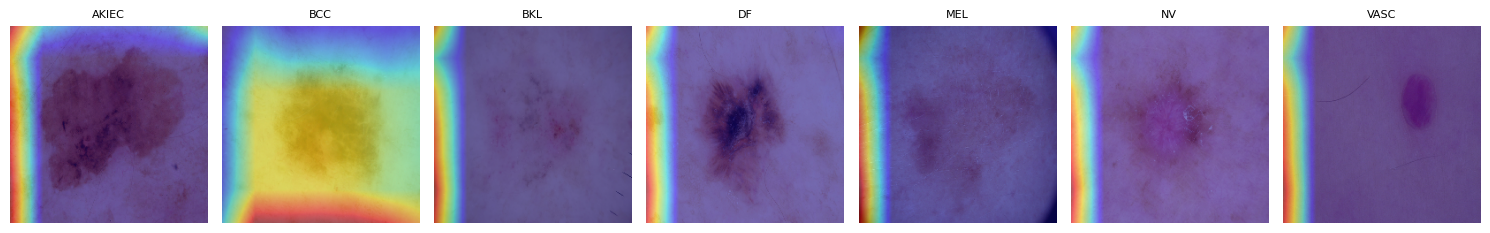

CPU times: user 10.9 s, sys: 596 ms, total: 11.5 s
Wall time: 11 s


In [46]:
# FASTER SCORE CAM - HIGHER max_N VALUE
%%time
from matplotlib import pyplot as plt, cm
from tf_keras_vis.scorecam import Scorecam
import cv2
import numpy as np

# scorecam variable
scorecam = Scorecam(model, model_modifier=replace2linear)

# use faster scorecam parameters with higher max_N
cam = scorecam(score, X, penultimate_layer=-1, max_N=50)

# no. of images
num_images = len(image_titles)

# single row
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

    # convert image_array[i] to uint8 to match heatmap data type
    image = np.uint8(image_array[i] * 255)

    combined_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

    axes[i].set_title(title, fontsize=8)
    axes[i].imshow(combined_image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

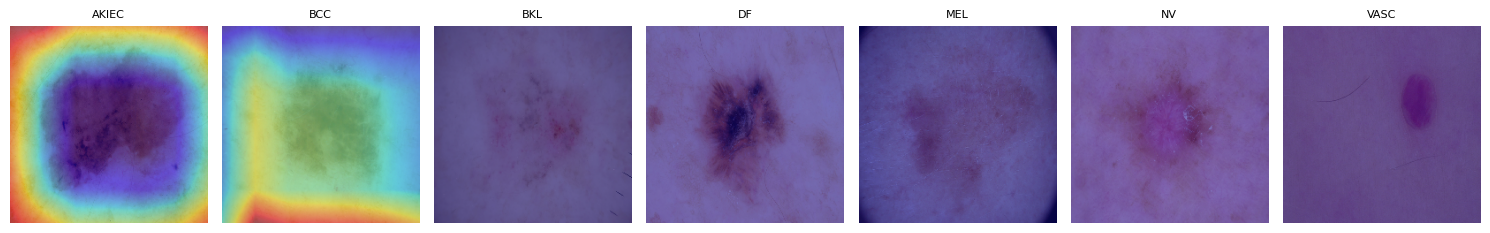

CPU times: user 1.74 s, sys: 274 ms, total: 2.01 s
Wall time: 1.7 s


In [47]:
# #GRADCAM

# %%time
# from matplotlib import pyplot as plt, cm
# from tf_keras_vis.gradcam import Gradcam
# import cv2
# import numpy as np

# # gradcam variable
# gradcam = Gradcam(model, model_modifier=replace2linear)

# # generate heatmap
# cam = gradcam(score, X, penultimate_layer=-1)

# # no. of images
# num_images = len(image_titles)

# # single row
# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# for i, title in enumerate(image_titles):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

#     # convert image_array[i] to uint8 to match heatmap data type.
#     image = np.uint8(image_array[i] * 255)

#     combined_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

#     axes[i].set_title(title, fontsize=8)
#     axes[i].imshow(combined_image)
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

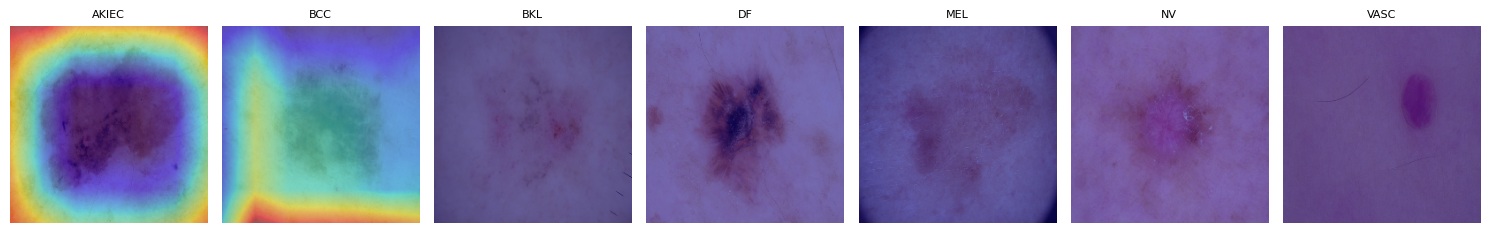

CPU times: user 1.73 s, sys: 300 ms, total: 2.03 s
Wall time: 1.77 s


In [48]:
# #GRADCAM++

# %%time
# from matplotlib import pyplot as plt, cm
# from tf_keras_vis.gradcam import GradcamPlusPlus
# import cv2
# import numpy as np

# # gradcam++ variable
# gradcam_plus_plus = GradcamPlusPlus(model, model_modifier=replace2linear)

# # heatmap generation
# cam = gradcam_plus_plus(score, X, penultimate_layer=-1)

# # no. of images
# num_images = len(image_titles)

# # single row
# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# for i, title in enumerate(image_titles):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

#     # convert image_array[i] to uint8 to match heatmap data type.
#     image = np.uint8(image_array[i] * 255)

#     # overlay heatmap with image
#     combined_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

#     axes[i].set_title(title, fontsize=8)
#     axes[i].imshow(combined_image)
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()




---



---

